# How to stream LLM tokens from your graph

In this example, we will stream tokens from the language model powering an
agent. We will use a ReAct agent as an example. The tl;dr is to use
[streamEvents](https://js.langchain.com/v0.2/docs/how_to/chat_streaming/#stream-events)
([API Ref](https://api.js.langchain.com/classes/langchain_core_runnables.Runnable.html#streamEvents)).

<div class="admonition info">
    <p class="admonition-title">Note</p>
    <p>
      If you are using a version of <code>@langchain/core</code> < 0.2.3, when calling chat models or LLMs you need to call <code>await model.stream()</code> within your nodes to get token-by-token streaming events, and aggregate final outputs if needed to update the graph state. In later versions of <code>@langchain/core</code>, this occurs automatically, and you can call <code>await model.invoke()</code>.
      <br>
      For more on how to upgrade <code>@langchain/core</code>, check out <a href="https://js.langchain.com/v0.2/docs/how_to/installation/#installing-integration-packages">the instructions here</a>.
    </p>

</div>

This how-to guide closely follows the others in this directory, showing how to
incorporate the functionality into a prototypical agent in LangGraph.

This works for
[StateGraph](/langgraphjs/reference/classes/langgraph.StateGraph.html)
and all its subclasses, such as
[MessageGraph](/langgraphjs/reference/classes/langgraph.MessageGraph.html).

<div class="admonition info">
    <p class="admonition-title">Streaming Support</p>
    <p>
        Token streaming is supported by many, but not all chat models. Check to see if your LLM integration supports token streaming <a href="https://js.langchain.com/v0.2/docs/integrations/chat/">here (doc)</a>. Note that some integrations may support <i>general</i> token streaming but lack support for streaming tool calls.
    </p>
</div>

<div class="admonition tip">
    <p class="admonition-title">Note</p>
    <p>
        In this how-to, we will create our agent from scratch to be transparent (but verbose). You can accomplish similar functionality using the <code>createReactAgent({ llm, tools })</code> (<a href="/langgraphjs/reference/functions/langgraph_prebuilt.createReactAgent.html">API doc</a>) constructor. This may be more appropriate if you are used to LangChain's <a href="https://js.langchain.com/v0.2/docs/how_to/agent_executor">AgentExecutor</a> class.
    </p>
</div>

## Setup

This guide will use OpenAI's GPT-4o model. We will optionally set our API key
for [LangSmith tracing](https://smith.langchain.com/), which will give us
best-in-class observability.

---

In [1]:
// process.env.OPENAI_API_KEY = "sk_...";

// Optional, add tracing in LangSmith
// process.env.LANGCHAIN_API_KEY = "ls__...";
// process.env.LANGCHAIN_CALLBACKS_BACKGROUND = "true";
// process.env.LANGCHAIN_TRACING = "true";
// process.env.LANGCHAIN_PROJECT = "Stream Tokens: LangGraphJS";

## Define the state

The state is the interface for all of the nodes in our graph.


In [2]:
import { Annotation } from "@langchain/langgraph";
import { BaseMessage } from "@langchain/core/messages";

const GraphState = Annotation.Root({
  messages: Annotation<BaseMessage[]>({
    reducer: (x, y) => x.concat(y),
  }),
});

## Set up the tools

First define the tools you want to use. For this simple example, we'll create a placeholder search engine, but see the documentation [here](https://js.langchain.com/v0.2/docs/how_to/custom_tools) on how to create your own custom tools.

In [3]:
import { tool } from "@langchain/core/tools";
import { z } from "zod";

const searchTool = tool((_) => {
  // This is a placeholder for the actual implementation
  return "Cold, with a low of 3℃";
}, {
  name: "search",
  description:
    "Use to surf the web, fetch current information, check the weather, and retrieve other information.",
  schema: z.object({
    query: z.string().describe("The query to use in your search."),
  }),
});

await searchTool.invoke({ query: "What's the weather like?" });

const tools = [searchTool];

We can now wrap these tools in a prebuilt
[ToolNode](/langgraphjs/reference/classes/langgraph_prebuilt.ToolNode.html).
This object will actually run the tools (functions) whenever they are invoked by
our LLM.

In [4]:
import { ToolNode } from "@langchain/langgraph/prebuilt";

const toolNode = new ToolNode<typeof GraphState.State>(tools);

## Set up the model

Now load the [chat model](https://js.langchain.com/v0.2/docs/concepts/#chat-models).

1. It should work with messages. We will represent all agent state in the form
   of messages, so it needs to be able to work well with them.
2. It should work with
   [tool calling](https://js.langchain.com/v0.2/docs/how_to/tool_calling/#passing-tools-to-llms),
   meaning it can return function arguments in its response.

<div class="admonition tip">
    <p class="admonition-title">Note</p>
    <p>
        These model requirements are not general requirements for using LangGraph - they are just requirements for this one example.
    </p>
</div>

In [5]:
import { ChatOpenAI } from "@langchain/openai";

const model = new ChatOpenAI({ model: "gpt-4o", temperature: 0 });

After you've done this, we should make sure the model knows that it has these
tools available to call. We can do this by calling
[bindTools](https://v01.api.js.langchain.com/classes/langchain_core_language_models_chat_models.BaseChatModel.html#bindTools).

In [6]:
const boundModel = model.bindTools(tools);

## Define the graph

We can now put it all together.

In [7]:
import { StateGraph, END } from "@langchain/langgraph";
import { AIMessage } from "@langchain/core/messages";

const routeMessage = (state: typeof GraphState.State) => {
  const { messages } = state;
  const lastMessage = messages[messages.length - 1] as AIMessage;
  // If no tools are called, we can finish (respond to the user)
  if (!lastMessage?.tool_calls?.length) {
    return END;
  }
  // Otherwise if there is, we continue and call the tools
  return "tools";
};

const callModel = async (
  state: typeof GraphState.State,
): Promise<Partial<typeof GraphState.State>> => {
  // For versions of @langchain/core < 0.2.3, you must call `.stream()`
  // and aggregate the message from chunks instead of calling `.invoke()`.
  const { messages } = state;
  const responseMessage = await boundModel.invoke(messages);
  return { messages: [responseMessage] };
};

const workflow = new StateGraph(GraphState)
  .addNode("agent", callModel)
  .addNode("tools", toolNode)
  .addEdge("__start__", "agent")
  .addConditionalEdges("agent", routeMessage)
  .addEdge("tools", "agent");

const agent = workflow.compile();

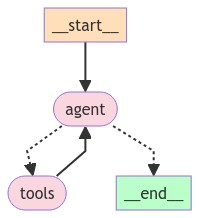

In [8]:
import * as tslab from "tslab";

const runnableGraph = agent.getGraph();
const image = await runnableGraph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

## How to stream tool calls

You can now run your agent. Let's first look at an example of streaming back intermediate tool calls. This is not supported by all providers, but some support token-level streaming of tool invocations.

To get the partially populated tool calls, you can access the message chunks' `tool_call_chunks` property:

In [9]:
import type { AIMessageChunk } from "@langchain/core/messages";

const eventStream = await agent.streamEvents(
  { messages: [["user", "What's the weather like today?"]] },
  {
    version: "v2",
  },
);

for await (const { event, data } of eventStream) {
  if (event === "on_chat_model_stream") {
    const msg = data.chunk as AIMessageChunk;
    if (msg.tool_call_chunks !== undefined && msg.tool_call_chunks.length > 0) {
      console.log(msg.tool_call_chunks);
    }
  }
}

[
  {
    name: 'search',
    args: '',
    id: 'call_ziGo5u8fYyqQ78SdLZTEC9Vg',
    index: 0,
    type: 'tool_call_chunk'
  }
]
[
  {
    name: undefined,
    args: '{"',
    id: undefined,
    index: 0,
    type: 'tool_call_chunk'
  }
]
[
  {
    name: undefined,
    args: 'query',
    id: undefined,
    index: 0,
    type: 'tool_call_chunk'
  }
]
[
  {
    name: undefined,
    args: '":"',
    id: undefined,
    index: 0,
    type: 'tool_call_chunk'
  }
]
[
  {
    name: undefined,
    args: 'current',
    id: undefined,
    index: 0,
    type: 'tool_call_chunk'
  }
]
[
  {
    name: undefined,
    args: ' weather',
    id: undefined,
    index: 0,
    type: 'tool_call_chunk'
  }
]
[
  {
    name: undefined,
    args: '"}',
    id: undefined,
    index: 0,
    type: 'tool_call_chunk'
  }
]


Because this is a ReAct-style agent, this will only log intermediate steps and not the final response because the model generates a final response with no tool calls when it no longer needs to gather more information from calling tools.

## Streaming final responses

### ReAct agents

For ReAct-style agents, you know that as soon as you start message chunks with no `tool_call_chunks`, the model is responding directly to the user. So we can flip the conditional like this to only log tokens from the final response:

In [10]:
const eventStreamFinalRes = await agent.streamEvents(
  { messages: [["user", "What's the weather like today?"]] },
  { version: "v2" });

for await (const { event, data } of eventStreamFinalRes) {
  if (event === "on_chat_model_stream") {
    const msg = data.chunk as AIMessageChunk;
    if (!msg.tool_call_chunks?.length) {
      console.log(msg.content);
    }
  }
}



The
 weather
 today
 is
 cold
,
 with
 a
 low
 of
 
3
℃
.



### Other graphs

If your graph has multiple model calls in multiple nodes and there's one that will always be called last, you can distinguish that model by assigning it a run name or a tag. To illustrate this, declare a new graph like this:

In [11]:
import { HumanMessage } from "@langchain/core/messages";

const OtherGraphState = Annotation.Root({
  messages: Annotation<BaseMessage[]>({
    reducer: (x, y) => x.concat(y),
  }),
});

const respond = async (state: typeof OtherGraphState.State): Promise<Partial<typeof OtherGraphState.State>> => {
  const { messages } = state;
  const model = new ChatOpenAI({ model: "gpt-4o", temperature: 0 });
  const responseMessage = await model.invoke(messages);
  return {
    messages: [responseMessage],
  }
};

const summarize = async (state: typeof OtherGraphState.State): Promise<Partial<typeof OtherGraphState.State>> => {
  const { messages } = state;
  // Assign the final model call a run name
  const model = new ChatOpenAI({
    model: "gpt-4o",
    temperature: 0
  }).withConfig({ runName: "Summarizer" });
  const userMessage = new HumanMessage("Now, summarize the above messages")
  const responseMessage = await model.invoke([
    ...messages,
    userMessage,
  ]);
  return { 
    messages: [userMessage, responseMessage]
  };
}

const otherWorkflow = new StateGraph(OtherGraphState)
  .addNode("respond", respond)
  .addNode("summarize", summarize)
  .addEdge("__start__", "respond")
  .addEdge("respond", "summarize")
  .addEdge("summarize", "__end__");

const otherGraph = otherWorkflow.compile();

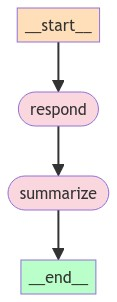

In [12]:
const otherRunnableGraph = otherGraph.getGraph();
const otherImage = await otherRunnableGraph.drawMermaidPng();
const otherArrayBuffer = await otherImage.arrayBuffer();

await tslab.display.png(new Uint8Array(otherArrayBuffer));

Now when we call `streamEvents`, we can see that we can now filter on run name to only see the final summary generation of the current chat history:

In [13]:
const otherEventStream = await otherGraph.streamEvents(
  { messages: [["user", "What's the capital of Nepal?"]] },
  { version: "v2" },
  { includeNames: ["Summarizer"] }
);

for await (const { event, data } of otherEventStream) {
  if (event === "on_chat_model_stream") {
    console.log(data.chunk.content);
  }
}


You
 asked
 about
 the
 capital
 of
 Nepal
,
 and
 I
 responded
 that
 it
 is
 Kathmandu
.



And you can see the resulting chunks are only ones from the final summary model call.

## Next steps

You've now seen some ways to stream LLM tokens from within your graph. Next, check out some of the other how-tos around streaming by going [to this page](/langgraphjs/how-tos/#streaming).